# Multimodal Masked Autoencoder test

Motivated by [NASA and IBM's Prithvi](https://arxiv.org/abs/2412.02732) and [EPFL's MultiMAE](https://arxiv.org/abs/2204.01678), we seek to construct a [Vision Transformer](https://arxiv.org/abs/2010.11929)-based Multimodal [Masked Autoencoder](https://arxiv.org/pdf/2111.06377), capable of encoding combinations of temporal, spatial, and spatiotemporal data. We test the principle using the [Moving MNIST dataset](https://www.cs.toronto.edu/~nitish/unsupervised_video/).

In [5]:
%load_ext autoreload
%autoreload 2

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from pytorch_lightning import Trainer, callbacks
import sys
import torch
from torch.utils.data import DataLoader, default_collate, RandomSampler
from torchvision import datasets

sys.path.insert(0, '../..')
from src.FRAME_FM.models.mmmae import MultimodalMaskedAutoencoder

data_path = Path("../../experiments")

def divide_batch(batch):
    batch_frames = default_collate(batch).transpose(1, 2) / 8
    batch_frame0 = batch_frames[:, :, 0]
    batch_mean_x = torch.inner(torch.linspace(0, 1, 64), batch_frames.mean(dim=-1))
    batch_mean_x = batch_mean_x / batch_frames.mean(dim=-1).sum(dim=-1)
    return [batch_frames, batch_frame0, batch_mean_x]

def construct_moving_mnist_dataloader(directory, train=True):
    dataset = datasets.MovingMNIST(directory, download=True)
    dataloader = DataLoader(
        dataset,
        sampler=RandomSampler(range(900)) if train else range(900, 1000),
        batch_size=16,
        drop_last=True,
        collate_fn=divide_batch,
        )
    return dataloader

dataloader_train = construct_moving_mnist_dataloader(data_path, train=True)
dataloader_test = construct_moving_mnist_dataloader(data_path, train=False)

mmmae = MultimodalMaskedAutoencoder(
    input_shapes=[(20, 64, 64), (64, 64), (20,)],  # Shapes of inputs (in pixels)
    n_channels=[1, 1, 1],  # Number of channels of inputs
    patch_shapes=[(4, 8, 8), (8, 8), (4,)],  # Shapes of patches over which attention is to operate
    encoder_embed_dim=8,  # Number of dimensions into which each patch is embedded
    encoder_depth=16,  # Number of attention layers for encoding
    encoder_num_heads=4,  # Number of attention heads per encoding layer
    decoder_embed_dim=4,  # Number of dimensions from which to reconstruct each patch
    decoder_depth=4,  # Number of attention layers for decoding
    decoder_num_heads=4,  # Number of attention heads per decoding layer
    mlp_ratio=4.,  # Ratio between dimensions of MLP layer and of embedding
    norm_layer=torch.nn.LayerNorm,  # Class of normalisation layer
    norm_token_loss=False,  # Whether to normalise target pixels in loss calculation
    )

mask_ratio = 0.5
load_checkpoint = False
checkpoint_path = data_path / "model_checkpoint.ckpt"
epochs = 2

ckpt_callback = callbacks.ModelCheckpoint(data_path, filename="model_checkpoint", save_top_k=1)
if load_checkpoint and checkpoint_path.is_file():
    mmmae.load_from_checkpoint(checkpoint_path)
trainer = Trainer(max_epochs=epochs, callbacks=[ckpt_callback], default_root_dir=data_path)
trainer.fit(model=mmmae, train_dataloaders=dataloader_train, val_dataloaders=dataloader_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
c:\Users\matarran\OneDrive - NERC\Documents\Projects\FRAME-FM\FRAME-FM\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory C:\Users\matarran\OneDrive - NERC\Documents\Projects\FRAME-FM\FRAME-FM\experiments exists and is not empty.

  | Name            | Type       | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | input_embedders | ModuleList | 8.9 K  | train | 0    
1 | blocks          | ModuleList | 14.0 K | train | 0    
2 | norm            | LayerNorm  | 16     | train | 0    
3 | decoder_embed   | Linear     | 36     | train | 0    
4 | decoder_blocks  | ModuleList | 976    | train | 0    
5 | decoder_norm    | LayerNorm  | 8      | train | 0    
  | other params    | n/a        | 12     | n/a   | n/a  
---------------------------------------------------------------
19.2 K    Trainable params
4.7 K     Non-trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\matarran\OneDrive - NERC\Documents\Projects\FRAME-FM\FRAME-FM\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\matarran\OneDrive - NERC\Documents\Projects\FRAME-FM\FRAME-FM\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Results appear no better than random, but demonstrate clear dependence of predictions on the input:

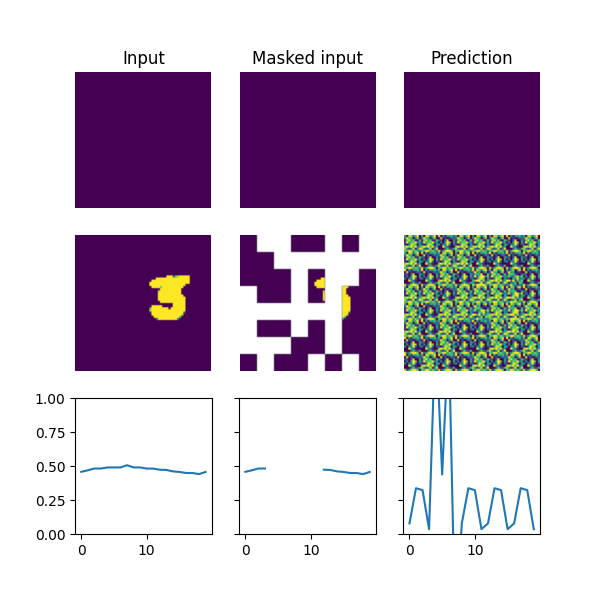

In [6]:
%matplotlib widget

inputs = next(iter(dataloader_test))
masked_inputs, preds = [], []
mmmae.eval()
with torch.no_grad():
    _, token_preds, mask = mmmae(inputs, mask_ratio=mask_ratio)
start_id = 0
for embedder, input, pred_tokens in zip(mmmae.input_embedders, inputs, token_preds):
    input_mask = mask[:, start_id:start_id + embedder.n_patches]
    masked_patches = torch.where(
        torch.unsqueeze(input_mask, -1) == 0, embedder.tokenify(input), np.nan
        )
    masked_inputs.append(embedder.untokenify(masked_patches))
    preds.append(embedder.untokenify(pred_tokens))

fig, axs = plt.subplots(3, 3, figsize=[6, 6])
axs[0, 0].set_title("Input")
axs[0, 1].set_title("Masked input")
axs[0, 2].set_title("Prediction")
plt_imgs = [ax.imshow(np.zeros([64, 64]), vmin=0, vmax=1) for ax in axs[0]]
for ax_row in axs[:2]:
    for ax in ax_row:
        ax.set_axis_off()

axs[1, 0].imshow(inputs[1][0, 0], vmin=0, vmax=1)
axs[1, 1].imshow(masked_inputs[1][0, 0], vmin=0, vmax=1)
axs[1, 2].imshow(preds[1][0, 0], vmin=0, vmax=1)
axs[2, 0].plot(range(inputs[2].shape[-1]), inputs[2][0].flatten())
axs[2, 1].plot(range(inputs[2].shape[-1]), masked_inputs[2][0].flatten())
axs[2, 2].plot(range(inputs[2].shape[-1]), preds[2][0].flatten())
axs[2, 0].set_ylim([0, 1])
for ax in axs[2, 1:]:
    ax.set_xlim(axs[2, 0].get_xlim())
    ax.set_ylim([0, 1])
    ax.set_yticklabels([])

def animate(frame):
    plt_imgs[0].set_array(inputs[0][0, 0, frame])
    plt_imgs[1].set_array(masked_inputs[0][0, 0, frame])
    plt_imgs[2].set_array(preds[0][0, 0, frame])
    return plt_imgs

animation = FuncAnimation(fig, animate, frames=20)